# Performing Spatial Joins in GeoPandas
This notebook covers how to use spatial joins in GeoPandas to combine datasets based on geographic relationships rather than matching columns.

## What Is a Spatial Join?
In pandas, a **column join** combines two datasets based on a shared column (e.g., zip code).

A GeoPandas **spatial join**, by contrast, combines datasets based on their **geographic relationship** (e.g., points within polygons).

### Example Use Cases
- Join restaurants (points) with neighborhoods (polygons)
- Match roads (lines) to cities (polygons)
- Combine pollution sensors (points) with state boundaries

## Setting Up Our Data
Let's assume we have two GeoDataFrames:
- `states`: U.S. states (polygons)
- `plants`: Power plants (points)

In [2]:
import geopandas as gpd

# Sample loading (replace with actual paths)
states_url = '../../geopandas_101_DATA/us/cb_2022_us_state_500k.zip'
plants_url = "../../geopandas_101_DATA/us/Power_Plants_in_the_US_5860152164617264051.geojson"

states = gpd.read_file(states_url)
plants = gpd.read_file(plants_url)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STATENS   56 non-null     object  
 2   AFFGEOID  56 non-null     object  
 3   GEOID     56 non-null     object  
 4   STUSPS    56 non-null     object  
 5   NAME      56 non-null     object  
 6   LSAD      56 non-null     object  
 7   ALAND     56 non-null     int64   
 8   AWATER    56 non-null     int64   
 9   geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 4.5+ KB
None
  STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      35  00897535  0400000US35    35     NM    New Mexico   00   
1      46  01785534  0400000US46    46     SD  South Dakota   00   
2      06  01779778  0400000US06    06     CA    California   00   
3      21  01779786  0400000US21    21     KY      Kentucky   00   
4

<Axes: >

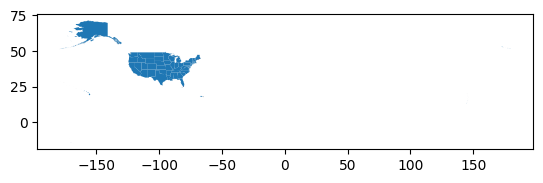

In [3]:
print(states.info())
print(states.head())
states.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13446 entries, 0 to 13445
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         13446 non-null  int32   
 1   OBJECTID    13446 non-null  int32   
 2   Plant_Code  13446 non-null  int32   
 3   Plant_Name  13446 non-null  object  
 4   Utility_ID  13446 non-null  int32   
 5   Utility_Na  13446 non-null  object  
 6   sector_nam  13446 non-null  object  
 7   Street_Add  13446 non-null  object  
 8   City        13446 non-null  object  
 9   County      13446 non-null  object  
 10  State       13446 non-null  object  
 11  Zip         13446 non-null  int32   
 12  PrimSource  13446 non-null  object  
 13  source_des  13446 non-null  object  
 14  tech_desc   13446 non-null  object  
 15  Install_MW  13446 non-null  float64 
 16  Total_MW    13446 non-null  float64 
 17  Bat_MW      13446 non-null  float64 
 18  Bio_MW      13446 non-null  float64 
 

<Axes: >

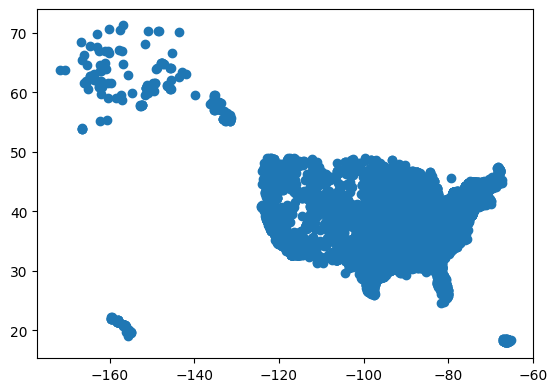

In [4]:
print(plants.info())
print(plants.head())
plants.plot()

## Coordinate Reference Systems (CRS) Must Match
Before performing a spatial join, ensure both GeoDataFrames use the same CRS.

In [8]:
print(states.crs)
print(plants.crs)

EPSG:4326
EPSG:4326


It doesn't really matter which CRS you choose, but they must be the same. But if they don't match, the results will be meaningless. 

To convert one to the other's CRS, use `.to_crs()`. 

In [7]:
states.to_crs(plants.crs, inplace=True)

## Performing the Spatial Join
Now that the CRSs match, we can join the data. We want to find which state each power plant is in.

In [9]:
plants.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'dwithin',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [22]:
joined = gpd.sjoin(plants, states, how="inner", predicate="within")
print(joined.shape)
joined.head()

(13433, 44)


,FID,OBJECTID,Plant_Code,Plant_Name,Utility_ID,Utility_Na,sector_nam,Street_Add,City,County,...,index_right,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
0,1,62897,1873,Tower,20910,Wolverine Power Supply Coop,Electric Utility,9663 Cooperative Road,Tower,Cheboygan,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
1,2,62898,1874,Caro,18895,Thumb Electric Coop of Mich,Electric Utility,2437 East Dayton Road,Caro,Tuscola,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
2,3,62899,1875,Ubly,18895,Thumb Electric Coop of Mich,Electric Utility,4159 Ubly Road,Ubly,Huron,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
3,4,62900,1877,George Johnson,20910,Wolverine Power Supply Coop,Electric Utility,1529 S 170th Ave,Hersey,Osceola,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
4,5,62901,1880,Claude Vandyke,20910,Wolverine Power Supply Coop,Electric Utility,3150 143rd Ave,Dorr,Allegan,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874


In [ ]:
joined[joined['State'] != joined['NAME']][['State', 'NAME']]

### Join Parameters Explained:
- `plants`: The GeoDataFrame whose geometry (points) we keep
- `states`: The GeoDataFrame we are joining to (polygons)
- `how='inner'`: Keeps only points that fall within a polygon
- `predicate='within'`: Tests whether each point is inside a polygon

## What Did We Get?
The result contains:
- All columns from `plants`
- All columns from `states`, except for`geometry`, because we kept the `plants` geometry.

Example: `megawatts`, `plant`, `source` (from plants) + `name`, `population` (from states)

## Aggregating Results
Now that each power plant has state information, we can group and analyze. For example, how many plants does each state have?

In [24]:
joined['NAME'].value_counts()

NAME
California              1786
New York                1021
Texas                    920
North Carolina           919
Minnesota                781
Massachusetts            653
Illinois                 408
New Jersey               400
Florida                  321
Colorado                 300
Iowa                     297
Oregon                   281
Michigan                 274
Georgia                  267
Pennsylvania             260
Wisconsin                250
Virginia                 240
Maine                    230
Indiana                  210
South Carolina           208
Maryland                 206
Ohio                     200
Kansas                   185
Arizona                  173
Connecticut              171
Alaska                   151
Washington               146
Idaho                    145
New Mexico               145
Oklahoma                 140
Missouri                 130
Nebraska                 130
Utah                     122
Vermont                  114
Nevada   

### Count Coal Plants by State

In [32]:
coal = joined.loc[joined['PrimSource'] == 'coal']
coal['NAME'].value_counts()

NAME
Texas             13
Pennsylvania      13
Indiana           12
Wyoming           11
West Virginia     10
Minnesota          8
Missouri           8
Iowa               8
Illinois           8
Kentucky           8
Nebraska           8
Ohio               7
North Dakota       7
Wisconsin          6
Michigan           6
Kansas             5
Colorado           5
Utah               5
Alaska             5
Arkansas           5
Tennessee          4
Montana            4
South Carolina     4
Oklahoma           3
Arizona            3
New Hampshire      2
Louisiana          2
North Carolina     2
Georgia            2
Florida            2
Virginia           2
Nevada             2
New Mexico         1
Alabama            1
South Dakota       1
Maryland           1
Washington         1
California         1
Mississippi        1
Puerto Rico        1
Name: count, dtype: int64

## Summary
- Spatial joins let you combine datasets based on geography.
- Always match CRS before a join.
- Use `predicate='within'` to find points inside polygons.
- Choose `how='left'` or `how='inner'` based on whether unmatched records should be kept.
- You can now perform powerful analyses like counting points per region.

# Changing the order of the join
Changing the order of datasets in a spatial join affects the result—particularly the geometry column. Depending on the values of the `how` and `op` parameters, changing the order can have effects or no effect at all in the results.

## Join: Power Plants within States (Points First)
This keeps power plant geometries and adds columns from the states they fall inside.

In [42]:
plants_with_states = gpd.sjoin(plants, states, how="inner", predicate="within")
print(plants_with_states['geometry'])
plants_with_states.head()

0         POINT (-84.29497 45.36282)
1           POINT (-83.3278 43.4659)
2           POINT (-82.9388 43.7217)
3            POINT (-85.426 43.8393)
4            POINT (-85.8551 42.731)
                    ...             
13441        POINT (-118.109 34.608)
13442     POINT (-79.28172 42.50275)
13443     POINT (-77.74272 43.18913)
13444     POINT (-75.90345 42.33782)
13445    POINT (-120.63443 37.08391)
Name: geometry, Length: 13433, dtype: geometry


,FID,OBJECTID,Plant_Code,Plant_Name,Utility_ID,Utility_Na,sector_nam,Street_Add,City,County,...,index_right,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
0,1,62897,1873,Tower,20910,Wolverine Power Supply Coop,Electric Utility,9663 Cooperative Road,Tower,Cheboygan,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
1,2,62898,1874,Caro,18895,Thumb Electric Coop of Mich,Electric Utility,2437 East Dayton Road,Caro,Tuscola,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
2,3,62899,1875,Ubly,18895,Thumb Electric Coop of Mich,Electric Utility,4159 Ubly Road,Ubly,Huron,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
3,4,62900,1877,George Johnson,20910,Wolverine Power Supply Coop,Electric Utility,1529 S 170th Ave,Hersey,Osceola,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874
4,5,62901,1880,Claude Vandyke,20910,Wolverine Power Supply Coop,Electric Utility,3150 143rd Ave,Dorr,Allegan,...,44,26,01779789,0400000US26,26,MI,Michigan,00,146619145715,103867917874


## Swapping the Join Order: States with Power Plants
Now we place `states` first and `plants` second. This will:
- Keep the **geometry of states**
- Append the **columns from matching plants**

In the original example, we were looking for plants that were within states. In this case, we are looking for states that contain plants. To reflect this reversal, we also reverse the operation feature `op` from `within` to `contains`.

In [45]:
states_with_plants = gpd.sjoin(states, plants, how="inner", predicate="contains")
print(states_with_plants['geometry'])
states_with_plants.head()

0     POLYGON ((-109.05017 31.48, -109.04984 31.4995...
0     POLYGON ((-109.05017 31.48, -109.04984 31.4995...
0     POLYGON ((-109.05017 31.48, -109.04984 31.4995...
0     POLYGON ((-109.05017 31.48, -109.04984 31.4995...
0     POLYGON ((-109.05017 31.48, -109.04984 31.4995...
                            ...                        
55    MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...
55    MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...
55    MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...
55    MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...
55    MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...
Name: geometry, Length: 13433, dtype: geometry


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,...,NG_MW,Nuclear_MW,Crude_MW,Solar_MW,Wind_MW,Other_MW,Source,Period,Longitude,Latitude
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48, -109.04984 31.4995...",...,0.0,0.0,0.0,20.0,0.0,0.0,"EIA-860, EIA-860M and EIA-923",202502,-106.673333,31.792778
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48, -109.04984 31.4995...",...,313.0,0.0,0.0,0.0,0.0,0.0,"EIA-860, EIA-860M and EIA-923",202502,-106.547200,31.804700
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48, -109.04984 31.4995...",...,0.0,0.0,0.0,0.0,0.0,0.0,"EIA-860, EIA-860M and EIA-923",202502,-106.593260,31.811078
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48, -109.04984 31.4995...",...,0.0,0.0,0.0,1.9,0.0,0.0,"EIA-860, EIA-860M and EIA-923",202502,-107.587513,31.866730
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48, -109.04984 31.4995...",...,0.0,0.0,0.0,10.0,0.0,0.0,"EIA-860, EIA-860M and EIA-923",202502,-106.340986,32.034383


## Comparing Row Counts
Let's confirm both joins return the same number of matched rows.

In [46]:
print("Plants with States (geometry = points):", plants_with_states.shape)
print("States with Plants (geometry = polygons):", states_with_plants.shape)

Plants with States (geometry = points): (13433, 44)
States with Plants (geometry = polygons): (13433, 44)


## Key Differences
| Join Version               | Geometry Type | Column Order                |
|---------------------------|----------------|-----------------------------|
| `plants_with_states`      | Points         | Plant info, then State info |
| `states_with_plants`      | Polygons       | State info, then Plant info |

The rows are the same because both joins are **inner joins**, meaning only matched records are kept.

## Geometry Implications
In `states_with_plants`, **every row** has the geometry of the state, even if multiple rows refer to different power plants within that state.

## Counting Power Plants by State (Same Either Way)
We can still count how many power plants are in each state using `value_counts()` on the state name.

In [38]:
plants_with_states['NAME'].value_counts()

NAME
California              1786
New York                1021
Texas                    920
North Carolina           919
Minnesota                781
Massachusetts            653
Illinois                 408
New Jersey               400
Florida                  321
Colorado                 300
Iowa                     297
Oregon                   281
Michigan                 274
Georgia                  267
Pennsylvania             260
Wisconsin                250
Virginia                 240
Maine                    230
Indiana                  210
South Carolina           208
Maryland                 206
Ohio                     200
Kansas                   185
Arizona                  173
Connecticut              171
Alaska                   151
Washington               146
Idaho                    145
New Mexico               145
Oklahoma                 140
Missouri                 130
Nebraska                 130
Utah                     122
Vermont                  114
Nevada   

## Summary
- Reversing the order in a spatial join changes the **geometry** and **column order**, but not the **rows**.
- Use `op='within'` when the first dataset is **contained in** the second.
- Use `op='contains'` when the first dataset **contains** the second.
- Both methods can support the same kinds of analysis.

✅ Whether you start with points or polygons, understanding join direction helps manage geometry and prepare for visualization.

# "inner" vs "left" joins

## What Does `how` Mean in a Spatial Join?

The `how` parameter in `gpd.sjoin()` determines how unmatched rows are handled:
- `inner`: Only matched records are retained.
- `left`: All rows from the left GeoDataFrame are kept, even if they don’t match anything on the right.

### `how='inner'` example
Match all power plants with states. Drop plants that don't fall inside any state.

In [47]:
inner_join = gpd.sjoin(plants, states, how='inner', predicate='within')
print(f"Number of rows (inner join): {len(inner_join)}")

Number of rows (inner join): 13433


### `how='left'` example
Keep all power plants. If a plant isn't inside any state, its `state` columns will be `NaN`.

In [48]:
left_join = gpd.sjoin(plants, states, how='left', predicate='within')
print(f"Number of rows (left join): {len(left_join)}")

Number of rows (left join): 13446


### Finding Unmatched Points in Left Join
These are plants that were not matched to any state in the left join.

In [52]:
left_join[left_join['NAME'].isna()]

,FID,OBJECTID,Plant_Code,Plant_Name,Utility_ID,Utility_Na,sector_nam,Street_Add,City,County,...,index_right,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
232,233,63129,2494,Gowanus Gas Turbines Generating,54863,U S Power Generating Company LLC,IPP Non-CHP,420 2nd Avenue,Brooklyn,Kings,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
900,901,62594,972,Winnetka,20824,Village of Winnetka - (IL),Electric Utility,725 Tower Road,Winnetka,Cook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1547,1548,63796,6128,Amistad Dam & Power,9339,International Bound & Wtr Comm,Electric Utility,670 Texas Spur 349,Del Rio,Val Verde,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1736,1737,63650,4040,Port Washington Generating Station,20847,Wisconsin Electric Power Co,Electric Utility,146 South Wisconsin Street,Port Washington,Ozaukee,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3190,3191,64887,50329,West Point Treatment Plant,10004,King County Dept-Natural Res,Commercial CHP,1400 Discovery Park Blvd,Seattle,King,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3706,3707,65803,55525,MMSD South Shore Wastewater,12619,Milwaukee Metro Sewerage Dist,Commercial CHP,8500 S 5th Ave,Oak Creek,Milwaukee,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4215,4216,66312,56542,Kasidaya Creek Hydro,219,Alaska Power and Telephone Co,Electric Utility,Near Kasidaya Creek,Skagway,Skagway Hoonah Angoon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4889,4890,67386,58035,Block Island Wind Farm,57406,Deepwater Wind Block Island LLC,IPP Non-CHP,Offshore 3.5 Southeast of Bloc,NA,Washington,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6654,6655,68750,59693,Coastal Virginia Offshore Wind (CVOW) Pi,19876,Virginia Electric & Power Co,Electric Utility,24 miles offshore,Virginia Beach,Virginia Beach,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11960,11961,73657,65561,South Fork Wind,66027,Orsted Wind Power North America LLC,IPP Non-CHP,,East Hampton,Suffolk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Case Study: The Winnetka Power Plant
The Winnetka plant is a real power plant located on the shoreline of Illinois, and its coordinates fall slightly outside the state polygon.

In [55]:
"Winnetka" in left_join['Plant_Name'].values

True


### Why Join Type Matters
If we had used `inner`, we would have lost the Winnetka plant in our dataset, which could skew any geographic analysis.

This shows how **inner joins eliminate unmatched data silently**, while **left joins preserve all original data**, letting you manually inspect or correct it later.


## Revisiting Join Order and Geometry
Recall that the first GeoDataFrame you pass to `gpd.sjoin()` determines which geometry is kept in the result.

In [63]:
# Example:
# This keeps point geometry (plants)
plants_geom = gpd.sjoin(plants, states, how='inner', predicate='within')

# This keeps polygon geometry (states)
states_geom = gpd.sjoin(states, plants, how='inner', predicate='contains')

In [64]:
print("plants_geom shape:", plants_geom.shape)
print("states_geom shape:", states_geom.shape)

plants_geom shape: (13433, 44)
states_geom shape: (13433, 44)


## Now Let’s Try `left` With Polygons First
What happens when we put `states` first in a left join? We’ll keep all the states, but not necessarily all the plants.

In [65]:
left_states = gpd.sjoin(states, plants, how='left', predicate='contains')
print(f"Left join with states first: {len(left_states)} rows")

Left join with states first: 13437 rows


In [67]:
"Winnetka" in left_states['Plant_Name'].values  # Expected: False

False

## Summary Table: Join Type + Order
| Order         | `how='inner'`                   | `how='left'`                                    |
|---------------|----------------------------------|-------------------------------------------------|
| `plants, states` | Keeps matching plants only       | Keeps **all** plants; unmatched get `NaN`         |
| `states, plants` | Keeps matching states only       | Keeps **all** states; unmatched plants are lost |

- Join type (`how`) decides if unmatched rows are kept
- Join direction decides which geometry appears in the result


## ✅ Key Takeaways
- Use `how='left'` when you want to keep all rows from your main dataset (even if they don't match).
- Always check for unmatched records using `.isna()` on join columns.
- Use `predicate='within'` when joining points to polygons; use `predicate='contains'` to reverse.
- The first dataset in `gpd.sjoin()` determines the geometry kept.
